### Gabriel ANTUNES MOREIRA

This challenge serves two purposes:
1. introduce you to the world of Policy Gradient methods,
2. act as an evaluation for the RL class.

It is meant to be started in class and finished at home. It will require that you read quite a bit, then that you work on your own understanding, before answering the questions below.

The goal is simply to complete your discovery of Reinforcement Learning and to insure that you validate the skill-goals of the class. No traps here, I'd be happy to give a perfect mark to anybody that completes this exam and even better for those who go beyond (see the bonus questions for that). 

I recommend to answer both questions of the theoretical part first, then move on to the implementation part, then get back to the second question of the theoretical part (practice allows your ideas to mature).

# Policy gradient theorem (4 points)

Use your favourite source of information to:
1. quote the policy gradient theorem (2 points)
2. explain how it's useful (2 points)

The goal is not to have you search dark places of the web for references, but to build an understanding for yourself and render it in your own words. You can, for instance, use the following sources (you may suggest other ones):
- [Policy gradient algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html) on Lilian Weng's blog (OpenAI)
- [Policy gradient methods for reinforcement learning with function approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf), Sutton, McAllester, Sigh, Mansour. NIPS 2000.
- [Policy gradient methods](http://www.scholarpedia.org/article/Policy_gradient_methods) on Scholarpedia (written by Jan Peters).
- [Reinforcement Learning, an introduction](http://incompleteideas.net/book/the-book.html), the classic book by Sutton and Barto. Chapter 13.

**The policy gradient theorem:** Supposing we have a measure of performance of an algorithm (which is related to the value of the policy function $\pi$), usually specified as $J(\theta)$, the theorem states that the derivate of this function is independent of the state distribution. Instead, all the derivatives are with respect to $\theta$, a parameter used to tune the policy function.

Mathematically:

$$
\nabla J(\theta) \propto \sum_{s} \mu(s) \sum_{a} q_{\pi}(s,a)\nabla\pi(a\vert s, \theta)
$$

Where:
$\mu$ is the state distribution;
$\pi$ the policy function we wish to find
q is the $Q$ function, assuming the policy $\pi$.


**The meaning and usefulness of the policy gradient theorem:** The theorem is relevant because the performance depends not only on the sequence of actions but the sequence of states underlying those actions, i.e., the distribution of states where each action is made. Regardless, the question is how do we change the policy function so as to improve performance albeit we cannot link it to the state distribution? Thanks to this theorem, we know that we can parameterize the policy function and have a performance $J$ we can improve that does not need knowledge of the interaction (or mathematically, the derivative) between the policy and the state distribution. Since policy-parameterization has several advantages (stronger convergence, for example) this theorem allows us to implement algorithms in this fashion, instead of always seeking the best action without a defined "path"/policy beforehand. The policy can thus be learned via a gradient ascent of the performance which is usually smoother.

# REINFORCE (3 points)

- Implement the REINFORCE algorithm (from the Machine Learning journal paper "Simple statistical gradient-following algorithms for connectionist reinforcement learning" by Williams 1992, but also explained in all links above) on OpenAI gym's inverted pendulum.
- Plot the evolution of performance vs training time
- Discuss

---

In [135]:
import os
import gym
import random
import operator
import itertools
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from IPython.display import clear_output
from tensorflow.contrib.layers import fully_connected

%matplotlib inline
np.set_printoptions(precision=3)

'''
    CUDA is not working with Tensorflow in my computer due
    to version incompatibility
'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### First visualisation

In [136]:
env = gym.make('Pendulum-v0')
env.reset()
for i in range(100):
    env.render()
    action = np.random.normal(0,1)
    env.step(np.array([action]))
env.close()

### Action and state spaces

First I'll identify the specifications of the state and action spaces.

In [137]:
print('State-space (min max):')
print(env.observation_space.high)
print(env.observation_space.low)
print('\nAction-space (min max):')
print(env.action_space.low)
print(env.action_space.high)

State-space (min max):
[1. 1. 8.]
[-1. -1. -8.]

Action-space (min max):
[-2.]
[2.]


The state is identified by 3 parameters. These will be the input to the policy $\pi$. The output will be an action represented by a value within the interval $[-2,2]$. The action is a continuous value which makes the control problem slightly more difficult. To estimate the policy function I will use a neural net created with TensorFlow. Since we'll have to calculate a gradient, TF will make this easier. As the literature focuses on the theoretical part rather the computational implementation, and the examples I found online dealt mostly with discrete action spaces I tried with multiple NN configurations to find one that converges and succeeds in keeping the pendulum upright. 

For the NN used to approximate the $\pi$ function I tried three approaches:
* An output layer with just one neuron, using a $tanh$ activation function and then amplifying the value to the interval $[-2, 2]$;
* An output layer with one neuron but without activation function, clipping its value to $[-2, 2]$;
* Taking the $[-2, 2]$ and discretizing it into N possible actions;

Below I show the last approach, even though the results were not satisfactory.




In [255]:
class pi_estimator(object):
    
    def __init__(self, sess, env):
        # Pass TensorFlow session object
        self.sess = sess
        # Get number of inputs and outputs from environment
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = 16
        self.learning_rate = 0.01
        
        # Define number of hidden nodes
        self.n_hidden_nodes = 32
        
        # Set graph scope name
        self.scope = "policy_estimator"
        
        # Create network
        with tf.variable_scope(self.scope):
            initializer = tf.contrib.layers.xavier_initializer()
            
            # Define placholder tensors for state, actions, and rewards
            self.state = tf.placeholder(tf.float32, [None, self.n_inputs], 
                                        name='state')
            self.rewards = tf.placeholder(tf.float32, [None], name='rewards')
            self.actions = tf.placeholder(tf.int32, [None], name='actions')
            
            layer_1 = fully_connected(self.state, self.n_hidden_nodes,
                                      activation_fn=tf.nn.relu,
                                      weights_initializer=initializer)
            
            layer_2 = fully_connected(layer_1, self.n_hidden_nodes,
                                      activation_fn=tf.nn.relu,
                                      weights_initializer=initializer)
            
            output_layer = fully_connected(layer_2, self.n_outputs,
                                           activation_fn=None,
                                           weights_initializer=initializer)
            
            # Get probability of each action
            self.action_probs = tf.squeeze(
                tf.nn.softmax(output_layer - tf.reduce_max(output_layer)))
            
            # Get indices of actions
            indices = tf.range(0, tf.shape(output_layer)[0]) \
                * tf.shape(output_layer)[1] + self.actions
                
            selected_action_prob = tf.gather(tf.reshape(self.action_probs, [-1]), indices)
    
            # Define loss function
            self.loss = -tf.reduce_mean(tf.log(selected_action_prob) * self.rewards)

            # Get gradients and variables
            self.tvars = tf.trainable_variables(self.scope)
            self.gradient_holder = []
            for j, var in enumerate(self.tvars):
                self.gradient_holder.append(tf.placeholder(tf.float32, 
                    name='grads' + str(j)))
            
            self.gradients = tf.gradients(self.loss, self.tvars)
            
            # Minimize training error
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_op = self.optimizer.apply_gradients(
                zip(self.gradient_holder, self.tvars))
            
    def get_action(self, state):
        probs = self.sess.run([self.action_probs], 
                              feed_dict={
                                  self.state: state
                              })[0]
        return probs
    
    def update(self, gradient_buffer):
        feed = dict(zip(self.gradient_holder, gradient_buffer))
        self.sess.run([self.train_op], feed_dict=feed)

    def get_vars(self):
        net_vars = self.sess.run(tf.trainable_variables(self.scope))
        return net_vars

    def get_grads(self, states, actions, rewards):
        grads = self.sess.run([self.gradients], 
            feed_dict={self.state: states, self.rewards: rewards, self.actions: actions})[0]
        return grads   

In [256]:
def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards
    return discounted_rewards

Since there is no clear indicator of completion, I made each episode run for $n_{steps}$ iterations.

In [273]:
def reinforce(env, policy_estimator, num_episodes=500,
              batch_size=64, gamma=0.99):
    
    n_steps = 50
    total_rewards = []
    
    # Set up gradient buffers and set values to 0
    grad_buffer_pe = policy_estimator.get_vars()
    for i, g in enumerate(grad_buffer_pe):
        grad_buffer_pe[i] = g * 0
            
    for ep in range(num_episodes):
        if ep % 10 == 0:
            print('\nEpisode: %i' % ep, end='')
        s_0 = env.reset()
        reward = 0
        episode_log = []
        
        # Run through each episode
        for i in range(n_steps):
            if i % 10 == 0 and ep % 10 == 0:
                print('.', end='')
                
            action_probs = np.array(policy_estimator.get_action(s_0.reshape(1,-1)))
            
            # Get the probabilities over the actions
            actions = np.arange(0, 16)
            
            # Select action with highest probability
            action = actions[np.argmax(action_probs)]

            # Take a step
            s_1, r, complete, _ = env.step(np.array([-2+4*action/16]))
            
            # Append results to the episode log
            episode_log.append([s_0, action, r, s_1])
            
            s_0 = s_1
            
            # If complete, store results and calculate the gradients
            for i in range(n_steps):
                _episode_log = np.array(episode_log)
                
                # Store raw rewards and discount episode rewards
                total_rewards.append(_episode_log[:,2].sum())
                discounted_rewards = discount_rewards(_episode_log[:,2], gamma)

                # Calculate the gradients for the policy estimator and
                # add to buffer
                pe_grads = policy_estimator.get_grads(
                    states=np.vstack(_episode_log[:,0]),
                    actions=_episode_log[:,1],
                    rewards=discounted_rewards)
                for i, g in enumerate(pe_grads):
                    grad_buffer_pe[i] += g
                    
        # Update policy gradients based on batch_size parameter
        if ep % batch_size == 0 and ep != 0:
            policy_estimator.update(grad_buffer_pe)
            # Clear buffer values for next batch
            for i, g in enumerate(grad_buffer_pe):
                grad_buffer_pe[i] = g * 0
        if ep % 10 == 0:
            print('Ep-reward = %f' % _episode_log[:,2].sum())
            
    return total_rewards

In [274]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

tf.reset_default_graph()
sess = tf.Session()

pe = pi_estimator(sess, env)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

rewards = reinforce(env, pe)

No GPU found

Episode: 0.....Ep-reward = -147.077053

Episode: 10.....Ep-reward = -242.515831

Episode: 20.....Ep-reward = -344.257289

Episode: 30.....Ep-reward = -242.195968

Episode: 40.....Ep-reward = -426.283599

Episode: 50.....Ep-reward = -291.536668

Episode: 60.....Ep-reward = -378.877113

Episode: 70.....Ep-reward = -242.549217

Episode: 80.....Ep-reward = -276.274747

Episode: 90.....Ep-reward = -295.761761

Episode: 100.....Ep-reward = -300.639793

Episode: 110.....Ep-reward = -245.159778

Episode: 120.....Ep-reward = -265.486630

Episode: 130.....Ep-reward = -256.807903

Episode: 140.....Ep-reward = -388.296912

Episode: 150.....Ep-reward = -345.739310

Episode: 160.....Ep-reward = -255.780273

Episode: 170.....Ep-reward = -375.358921

Episode: 180.....Ep-reward = -323.516830

Episode: 190.....Ep-reward = -249.353214

Episode: 200.....Ep-reward = -409.624235

Episode: 210.....Ep-reward = -261.014415

Episode: 220.....Ep-reward = -374.972624

Episode: 230.....Ep-reward = -3

Performance plot:

Text(0, 0.5, 'Reward')

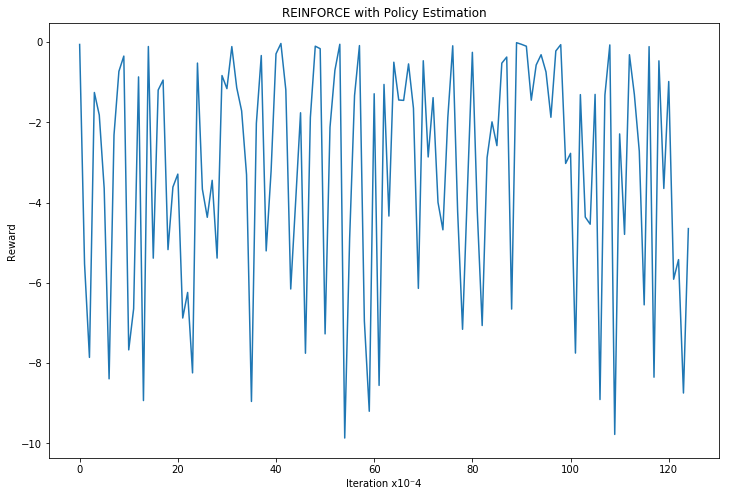

In [275]:
plt.figure(figsize=(12,8))
rewards = np.array(rewards)
plt.plot(rewards[np.arange(1,len(rewards), 10000)])
plt.title('REINFORCE with Policy Estimation')
plt.xlabel('Iteration x10⁻4')
plt.ylabel('Reward')

Pendulum visualization:

In [289]:
env.seed(1)
env.reset()
for i in range(500):
    env.render()
    action_prob = pe.get_action(s.reshape(1,-1))
    actions = np.arange(0, 16)
    action = actions[np.argmax(action_prob)]
    #print(-2+4*action/16)
    s, r, complete, _ = env.step(np.array([-2+4*action/16]))
    
env.close()

I believe the bad performance can be attributed to the following:
* The oscillatory nature of the environment might make it difficult for the optimizer to find the global minimum of the loss function. After tuning the parameters (learning rate, number of layers, number of neurons, the discount rate), the behaviour always ended up as some sort of periodic motion (the pendulum swinging from side to side), or it did reach the top (swinging higher each time until it finally reached it), but could not stay upright and would start just revolving rapidly.

* The discretization hinders the "comprehension" of the environment by the neural network, and was thus not the best way of implementing this algorithm.

* The Adam optimizer might not be adequate. Sometimes the loss function not only fluctuates might also diverges. Maybe using a variable learning rate could help? Maybe this would prevent the pendulum from being stuck in local minima of the loss function and it would actually explore the rest of the configurations.

* Bugs in the code.

# Actor-critic (3 points)

- Implement an Actor-Critic algorithm on OpenAI gym's inverted pendulum.
- Plot the evolution of performance vs training time
- Discuss

---

I implemented a **DDPG** actor-critic algorithm (as specified as bonus), which of all three (MTSC, Reinforce and AC) had the best results by far.

In [290]:
class Memory(object):
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.index = 0

    def store_transition(self, obs0, act, rwd, obs1, done):
        data = (obs0, act, rwd, obs1, done)
        if self.index >= len(self.buffer):
            self.buffer.append(data)
        else:
            self.buffer[self.index] = data
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        obs0, act, rwd, obs1, done = map(np.stack, zip(*batch))
        return obs0, act, rwd[:, np.newaxis], obs1, done[:, np.newaxis]


class ActorNetwork(object):
    def __init__(self, act_dim, name):
        self.act_dim = act_dim
        self.name = name

    def step(self, obs, reuse):
        with tf.variable_scope(self.name, reuse=reuse):
            h1 = tf.layers.dense(obs, 64, tf.nn.relu,
                                 kernel_initializer=tf.orthogonal_initializer(gain=np.sqrt(2)))
            h2 = tf.layers.dense(h1, 64, tf.nn.relu,
                                 kernel_initializer=tf.orthogonal_initializer(gain=np.sqrt(2)))
            action = tf.layers.dense(h2, self.act_dim, tf.nn.tanh,
                                 kernel_initializer=tf.orthogonal_initializer(gain=np.sqrt(2)))
        return action

    def choose_action(self, obs, reuse=False):
        action = self.step(obs, reuse)
        return action


class QValueNetwork(object):
    def __init__(self, name):
        self.name = name

    def step(self, obs, action, reuse):
        with tf.variable_scope(self.name, reuse=reuse):
            h1 = tf.layers.dense(obs, 64, tf.nn.relu,
                                 kernel_initializer=tf.orthogonal_initializer(gain=np.sqrt(2)))
            h1 = tf.concat([h1, action], axis=-1)
            h2 = tf.layers.dense(h1, 64, tf.nn.relu,
                                 kernel_initializer=tf.orthogonal_initializer(gain=np.sqrt(2)))
            value = tf.layers.dense(h2, 1,
                                    kernel_initializer=tf.orthogonal_initializer(gain=0.01))
            return value

    def get_q_value(self, obs, action, reuse=False):
        q_value = self.step(obs, action, reuse)
        return q_value

class DDPG(object):
    def __init__(self, act_dim, obs_dim, lr_actor, lr_q_value, gamma,
                 tau, action_noise_std):
        self.act_dim = act_dim
        self.obs_dim = obs_dim
        self.lr_actor = lr_actor
        self.lr_q_value = lr_q_value
        self.gamma = gamma
        self.tau = tau
        self.action_noise_std = action_noise_std

        self.OBS0 = tf.placeholder(tf.float32, [None, self.obs_dim], name="observations0")
        self.OBS1 = tf.placeholder(tf.float32, [None, self.obs_dim], name="observations1")
        self.ACT = tf.placeholder(tf.float32, [None, self.act_dim], name="action")
        self.RWD = tf.placeholder(tf.float32, [None, 1], name="reward")
        self.TARGET_Q = tf.placeholder(tf.float32, [None, 1], name="target_q_value")
        self.DONE = tf.placeholder(tf.float32, [None, 1], name="done")

        # Initialize Critic and Actor networks
        actor = ActorNetwork(self.act_dim, 'actor')
        q_value = QValueNetwork('q_value')

        # Target networks
        target_actor = ActorNetwork(self.act_dim, 'target_actor')
        target_q_value = QValueNetwork('target_q_value')

        # Initialize memory buffer
        self.memory = Memory(capacity=int(1e6))

        self.action = actor.choose_action(self.OBS0)
        self.q_value0_with_actor = q_value.get_q_value(self.OBS0, self.action)

        q_value0 = q_value.get_q_value(self.OBS0, self.ACT, reuse=True)
        target_action1 = target_actor.choose_action(self.OBS1)
        self.target_q_value1 = self.RWD + (1. - self.DONE) * self.gamma \
                               * target_q_value.get_q_value(self.OBS1, target_action1)

        q_value_loss = tf.reduce_mean(tf.square(q_value0 - self.TARGET_Q))
        self.q_value_train_op = tf.train.AdamOptimizer(learning_rate=self.lr_q_value).minimize(q_value_loss)

        actor_loss = -tf.reduce_mean(self.q_value0_with_actor)
        self.actor_train_op = tf.train.AdamOptimizer(learning_rate=self.lr_actor).minimize(actor_loss)

        self.actor_params = tf.global_variables('actor')
        self.target_actor_params = tf.global_variables('target_actor')
        self.q_value_params = tf.global_variables('q_value')
        self.target_q_value_params = tf.global_variables('target_q_value')

        self.target_init_updates = \
            [[tf.assign(ta, a), tf.assign(tq, q)]
             for ta, a, tq, q in zip(self.target_actor_params, self.actor_params,
                                     self.target_q_value_params, self.q_value_params)]

        self.target_soft_updates = \
            [[tf.assign(ta, (1 - tau) * ta + tau * a), tf.assign(tq, (1 - tau) * tq + tau * q)]
             for ta, a, tq, q in zip(self.target_actor_params, self.actor_params,
                                     self.target_q_value_params, self.q_value_params)]

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.target_init_updates)

    def step(self, obs):
        if obs.ndim < 2: obs = obs[np.newaxis, :]
        action = self.sess.run(self.action, feed_dict={self.OBS0: obs})
        action = action + np.random.normal(0, self.action_noise_std)
        action = np.clip(action, -2, 2).squeeze(axis=1)
        return action

    def learn(self):
        obs0, act, rwd, obs1, done = self.memory.sample(batch_size=128)

        target_q_value1 = self.sess.run(self.target_q_value1, feed_dict={self.OBS1: obs1, self.RWD: rwd,
                                                               self.DONE: np.float32(done)})

        self.sess.run(self.q_value_train_op,feed_dict={self.OBS0: obs0, self.ACT: act,
                                 self.TARGET_Q: target_q_value1})

        self.sess.run(self.actor_train_op, feed_dict={self.OBS0: obs0})

        self.sess.run(self.target_soft_updates)

        self.action_noise_std = max([self.action_noise_std * noise_decay, noise_min])

In [291]:
env = env.unwrapped

agent = DDPG(act_dim=env.action_space.shape[0], obs_dim=env.observation_space.shape[0],
                    lr_actor=0.0001, lr_q_value=0.001, gamma=0.99, tau=0.01, action_noise_std=1)

nepisode = 200
nstep = 200
iteration = 0
noise_decay = 0.9999
noise_min = 0.001
rwd_list = []

for i_episode in range(nepisode):
    obs0 = env.reset()
    ep_rwd = 0

    for t in range(nstep):
        act = agent.step(obs0)

        obs1, rwd, done, _ = env.step(act)

        agent.memory.store_transition(obs0, act, rwd/10, obs1, done)

        obs0 = obs1
        ep_rwd += rwd

        if iteration >= 128 * 3:
            agent.learn()

        iteration += 1
        
    rwd_list.append(ep_rwd)
    
    if i_episode % 10 == 0:
        print('Episode: %i' % i_episode, "| Cumulative reward: %i" % ep_rwd)

Episode: 0 | Cumulative reward: -1299
Episode: 10 | Cumulative reward: -1297
Episode: 20 | Cumulative reward: -733
Episode: 30 | Cumulative reward: -233
Episode: 40 | Cumulative reward: -350
Episode: 50 | Cumulative reward: 0
Episode: 60 | Cumulative reward: -119
Episode: 70 | Cumulative reward: -481
Episode: 80 | Cumulative reward: -126
Episode: 90 | Cumulative reward: -124
Episode: 100 | Cumulative reward: -239
Episode: 110 | Cumulative reward: -240
Episode: 120 | Cumulative reward: -241
Episode: 130 | Cumulative reward: -360
Episode: 140 | Cumulative reward: -616
Episode: 150 | Cumulative reward: -570
Episode: 160 | Cumulative reward: -365
Episode: 170 | Cumulative reward: -491
Episode: 180 | Cumulative reward: -359
Episode: 190 | Cumulative reward: -527


Pendulum visualization:

In [253]:
s = env.reset()
for i in range(500):
    env.render()
    action_prob = agent.step(s.reshape(1,-1))
    action = np.array([2*action_prob])
    s, r, complete, _ = env.step(np.array([action]))
env.close()

Plots:

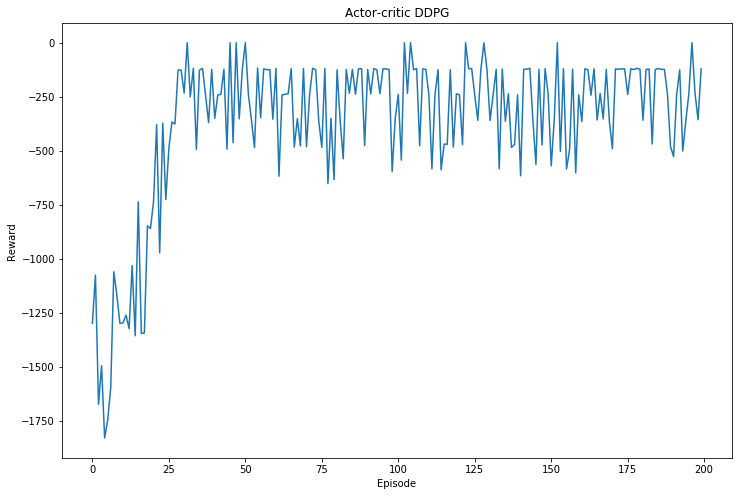

In [292]:
plt.figure(figsize=(12,8))
plt.plot(rwd_list)
plt.title('Actor-critic DDPG')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Monte Carlo Tree Search (5 points)

First note that the trick below allows you to set the pendulum state as you wish.

In [ ]:
env.reset()
env.unwrapped.state = [np.pi/3., 0.] # format: theta, thetaDot
env.render();

Note also that the integration time step is known.

In [ ]:
print("time step:", env.unwrapped.dt)

Finally, note that you can use the trick below to control the wall clock execution time of a method.

In [ ]:
import datetime

time_limit = datetime.timedelta(seconds=env.unwrapped.dt)
count = 0
begin = datetime.datetime.utcnow()
while datetime.datetime.utcnow() - begin < time_limit:
    count += 1
print(count)

Now use all those to implement a Monte Carlo Tree Search method that controls the pendulum in real time.

---

I decided to discretize the environment to apply the MCTS. For this, I tried several configurations. I coded the states using the angle (quantized in 16 possible values) and the angular speed (16 values). The action space was quantized into 32 possible actions. Even though some details might be lost in this process, the MCTS seemed to have good results with this implementation. I tried increasing the number of states, but this would generate search trees increasingly large which downgraded the performance (for the same learning periods).

In [156]:
'''
    Converts cos and sin to angle
    in degrees
'''
def cos_sin_theta(cos, sin):
    if sin >= 0:
        return np.arccos(cos)*180 / np.pi
    else:
        return -np.arccos(cos)*180 / np.pi

'''
    Converts angle theta in degrees
    to a integer identifying a state within a
    discrete space of size state_space_size 
'''
def angle_state(theta, state_space_size):
    if theta < 0:
        theta += 360
    state = min(state_space_size-1, int(theta / int(360 / state_space_size)))
    return state

In [169]:
def create_random_policy(env, state_space_size, action_space_size):
    policy = {}
    for angle_key in range(state_space_size):
        for speed_key in range(16):
            current_end = 0
            p = {}
            for action in range(action_space_size):
                p[action] = 1 / action_space_size
            key = (angle_key, speed_key)
            policy[key] = p
    return policy

def create_state_action_dictionary(env, policy, action_space_size):
    Q = {}
    for key in policy.keys():
         Q[key] = {a: 0.0 for a in range(0, action_space_size)}
    return Q

def run(state_space_size, action_space_size, env, policy, display=True):
    action_list = np.arange(-2, 2.1, 4/action_space_size)
    state = env.reset()
    cos, sin = state[0], state[1]
    theta_s = angle_state(cos_sin_theta(cos, sin), state_space_size)
    w_s = min(16-1, int((state[2]+8)*16 / 16))
    
    s = (theta_s, w_s)
    
    episode = []
    n_steps = 500
    
    for i in range(n_steps):
        if display:
            clear_output(True)
            env.render()

        timestep = []
        n = random.uniform(0, sum(policy[s].values()))
        top_range = 0
        for prob in policy[s].items():
            top_range += prob[1]
            if n < top_range:
                action = prob[0]
                break
                
        state, reward, finished, info = env.step(np.array([action_list[action]]))
        cos, sin = state[0], state[1]
        theta_s = angle_state(cos_sin_theta(cos, sin), state_space_size)
        w_s = min(16-1, int((state[2]+8)*16 / 16))
        s = (theta_s, w_s)
        timestep.append(s)
        timestep.append(action)
        timestep.append(reward)
        episode.append(timestep)

    if display:
        clear_output(True)
        env.render()
    return episode

In [179]:
def monte_carlo(env, state_space_size, action_space_size, episodes=100, policy=None, epsilon=0.001):
    
    if not policy:
        policy = create_random_policy(env, state_space_size, action_space_size)  # Create an empty dictionary to store state action values    
    
    Q = create_state_action_dictionary(env, policy, action_space_size) 
    returns = {} # 3.
    
    Gs = []
    for _ in range(episodes): # Looping through episodes
        G = 0 # Store cumulative reward in G (initialized at 0)
        episode = run(state_space_size, action_space_size, env, policy, display=False) 
        
        # for loop through reversed indices of episode array. 
        # The logic behind it being reversed is that the eventual reward would be at the end. 
        # So we have to go back from the last timestep to the first one propagating result from the future.
        
        for i in reversed(range(0, len(episode))):   
            s_t, a_t, r_t = episode[i] 
            state_action = (s_t, a_t)

            G += r_t # Increment total reward by reward on current timestep
            
            if not state_action in [(x[0], x[1]) for x in episode[0:i]]: # 
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]   
                    
                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action]) # Average reward across episodes
                
                Q_list = list(map(lambda x: x[1], Q[s_t].items())) # Finding the action with maximum value
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                max_Q = random.choice(indices)
                
                A_star = max_Q # 14.
                
                for a in policy[s_t].items(): # Update action probability for s_t in policy
                    if a[0] == A_star:
                        policy[s_t][a[0]] = 1 - epsilon + (epsilon / abs(sum(policy[s_t].values())))
                    else:
                        policy[s_t][a[0]] = (epsilon / abs(sum(policy[s_t].values())))
        Gs.append(G)
        if _ % 500 == 0:
            print('Episode: %i' % _)
    return [policy, Gs]

Below I use the class and functions defined above to perform the training on the Pendulum environment:

In [180]:
state_space_size = 16
action_space_size = 32

env = gym.make('Pendulum-v0')

results = monte_carlo(env, state_space_size, action_space_size, episodes=6000)

policy = results[0]

Episode: 0
Episode: 500
Episode: 1000
Episode: 1500
Episode: 2000
Episode: 2500
Episode: 3000
Episode: 3500
Episode: 4000
Episode: 4500
Episode: 5000
Episode: 5500


To see the results:

In [178]:
env.seed(11)
env.reset()
run(state_space_size, action_space_size, env, policy, display=True)
env.close()

Performance plot:

Text(0.5, 1.0, 'MCTS - Total reward per episode')

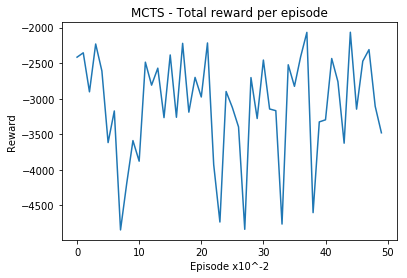

In [175]:
Gs = np.array(results[1])
plt.figure(figsize=(12,8))
plt.plot(Gs[np.arange(1,5000, 100)])
plt.xlabel('Episode x10^-2')
plt.ylabel('Reward')
plt.title('MCTS - Total reward per episode')

---
The perfomance was better than that of the Reinforce algorithm. In some cases the pendulum swings without reaching the top but when it does it can stay upright for a few moments. The only shortcoming is the apparent incapablity of the pendulum going from the "down" position to the top and staying upright. This might be due to the fact that while learning the action of the pendulum climbing to the right or the left side have equal probabilities. So if it starts climbing to the left and recedes several degrees aftewards due to gravity, e.g., the next action might be to move to the right, instead of continuing climbing to the top via the left side - which produces the swinging motion visible when the reset makes the pendulum start in a downward configuration.

The oscillations in the perfomance graph are a result of this, since in many episodes the above happens, and in the ones that the pendulum actually reaches the top, these instants represents a small percentage of the total number of iterations per episode, thus not having a great impact in the total cumulative reward for that episode.

# Bonus questions (extra points)

That part is free, I'm just providing hints.

- Take a look at the Deterministic Policy Gradient Theorem ([Deterministic policy gradient algorithms](http://proceedings.mlr.press/v32/silver14.html) by Silver et al, 2014) and the DDPG algorithm ([Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971), Lillicrap et al. 2015), discuss, implement, etc.
- Pick any more recent algorithm from [Lilian Weng's excellent summary](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html) and implement it in a demonstrative manner.
- Take a more difficult environment and try to solve it (for instance acrobot, cart-pole or mountain-car).
- Take a question that seems difficult for you or in the litterature and illustrate why, try to answer it, etc.
- Get inspiration from these papers from friends [CEM-RL](https://arxiv.org/abs/1810.01222), [overview on policy search](https://arxiv.org/abs/1803.04706), [GEP-PG](https://arxiv.org/abs/1802.05054).